In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import numpy as np

import sqlite3

import xgboost
from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm

from scipy import stats
from scipy.stats import t
from scipy.stats import poisson

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import joblib

import sys
sys.path.insert(0, '../../etl/')
from columns import *

In [2]:
variable = 'RecYards'
target_variable = 'Target' + variable

### DB connect

In [3]:
conn = sqlite3.connect('../../data/nfl.db')

In [4]:
sql_path = '../../sql/RecYards/recyards_wr_backtest_training.sql'.format(variable, variable.lower())
with open(sql_path, 'r') as sql_file:
    query = sql_file.read()

raw_data = pd.read_sql_query(query, conn)
print(len(raw_data))

10252


### Split data into train/test/validation

In [5]:
# Remove inf values (there aren't many)
raw_data = raw_data.loc[~raw_data.isin([np.inf, -np.inf]).any(axis=1)]
print(len(raw_data))

10252


In [6]:
def convert_odds(american_odds):
    # Convert American Odds to Decimal Odds
    if american_odds > 0:
        decimal_odds = 1 + (american_odds / 100)
    else:
        decimal_odds = 1 - (100 / american_odds)
    return decimal_odds

In [7]:
# Prepare features
lag_features = [i for i in raw_data.columns if ('Lag' in i)]

# Convert Moneyline to Decimal odds
raw_data['Moneyline'] = raw_data['Moneyline'].apply(lambda x: convert_odds(x)) 

#features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag','PositionId']
#features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag']

#all_features = features + [target_variable]

In [8]:
features = ['6GameRecTargetsPerTeamPlay',
 'CareerAvgRecYards',
 '6GameRecTargetShare',
 'SeasonAvgRecYards',
 'CareerRecPerTeamPlay',
 '6GameAvgRecYards',
 'SeasonAvgRecTargets',
 '6GameRecYardsPerTeamPlay',
 '3GameRecYardsPerTeamPlay',
 'CareerRecTargetsPerTeamPlay',
 '6GameMedianRecYards',
 '6GameRecPerTeamPlay',
 'SeasonRecPerTeamPlay',
 'SeasonRecTargetsPerTeamPlay',
 'SeasonRecTargetShare',
 'CareerAvgReceptions',
 'CareerAvgRecTd',
 'SeasonTeamRushTdPctAllowed',
 '3GameAvgLongestRec',
 'SeasonAvgRecTd',
 'SeasonTeamAdjPassYardsPerAtt',
 'SeasonRecYardsPerTeamPlay',
 'PointTotal',
 '3GameRecTargetShare',
 'Moneyline',
 'CareerTeamPassYardsPerAtt',
 'CareerMedianLongestRec',
 'CareerMedianTeamRushAttAllowed',
 'SeasonMedianTeamRushAttAllowed',
 'SeasonTeam4thDownPct',
 '6GameMedianLongestRec',
 '3GameMedianLongestRec',
 '3GameTeamPassIntPct',
 'SeasonYardsPerRec',
 'CareerTeamYardsPerRec',
 'SeasonTeamAdjPassYardsPerAttAllowed',
 '6GameAvgRecTargets',
 'SeasonAvgTeamTotalPlaysAllowed',
 '6GameYardsPerRush',
 'SeasonTeam3rdDownPct',
 'SeasonMedianTeamTotalPlays',
 'SeasonTeamPassYardsPerAtt',
 '3GameMedianTeamRushYardsAllowed']
all_features = features + [target_variable]

In [9]:
train_test_data = raw_data.copy()

# Replace Lag name in columns
train_test_data.columns = [i.replace('Lag','') for i in train_test_data.columns]

# Handle NAs and inf
#train_test_model_data = train_test_data[all_features].dropna(subset=all_features, how='any').replace([np.inf, -np.inf], np.nan).dropna()

# Split into X and y
X = train_test_data[features]
y = train_test_data[target_variable]

# Split train_test_data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [10]:
X.shape

(10252, 43)

### Use random search to narrow down hyperparameter grid

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\Sean\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.3705446009641986, 'gamma': 0.009110912825774864, 'learning_rate': 0.047777184302371364, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 386, 'reg_alpha': 0.6557226353807422, 'reg_lambda': 3.8549662096556503, 'subsample': 0.8408068344863948}
Best Score (R-squared): 0.2582840652980436
Test R-squared: 0.24964084590406366
Test RMSE: 31.8146
Test MAE: 24.5858


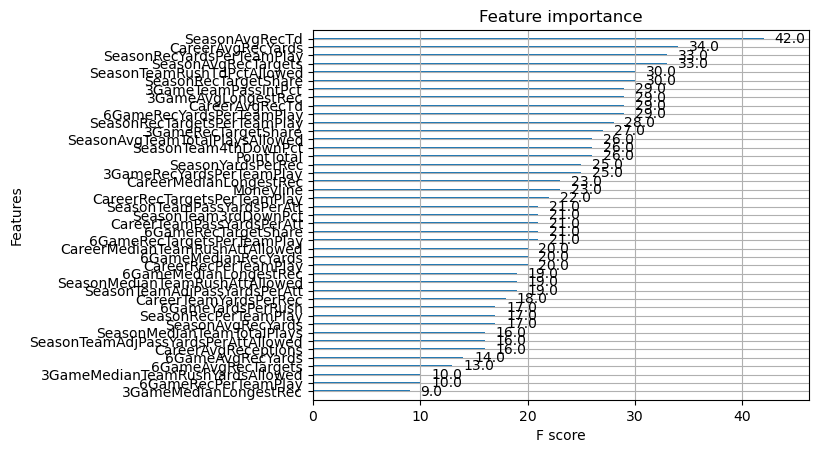

,TargetRecYards,pred_TargetRecYards,residuals
3404,18.0,24.585197,-6.585197
7630,3.0,37.782227,-34.782227
1402,104.0,39.620728,64.379272
9031,19.0,21.151331,-2.151331
8122,30.0,36.580421,-6.580421


In [11]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd

# Define parameter grid for RandomizedSearchCV with improved distributions
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.4),  
    'max_depth': randint(2, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.3, 0.7),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.001, 10)
}

# Create XGBoost regressor with GPU support (if available)
xgb = XGBRegressor(random_state=42, use_label_encoder=False)

# Set up cross-validation strategy
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV with efficient parameter settings
xgb_random = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_dist, 
    n_iter=300, 
    cv=kfolds, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model on the training data
xgb_random.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

# Display best parameters and scores
print("Best Parameters:", xgb_random.best_params_)
print("Best Score (R-squared):", xgb_random.best_score_)

# Evaluate on the test set
best_xgb = xgb_random.best_estimator_

y_pred_test = best_xgb.predict(X_test)
test_r2_score = best_xgb.score(X_test, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Test R-squared:", test_r2_score)
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Plot feature importance
plot_importance(best_xgb)
plt.show()

# Create and display output DataFrame
output_df = pd.DataFrame({target_variable: y_test, 'pred_' + target_variable: y_pred_test})
output_df['residuals'] = output_df[target_variable] - output_df['pred_' + target_variable]
output_df.head()


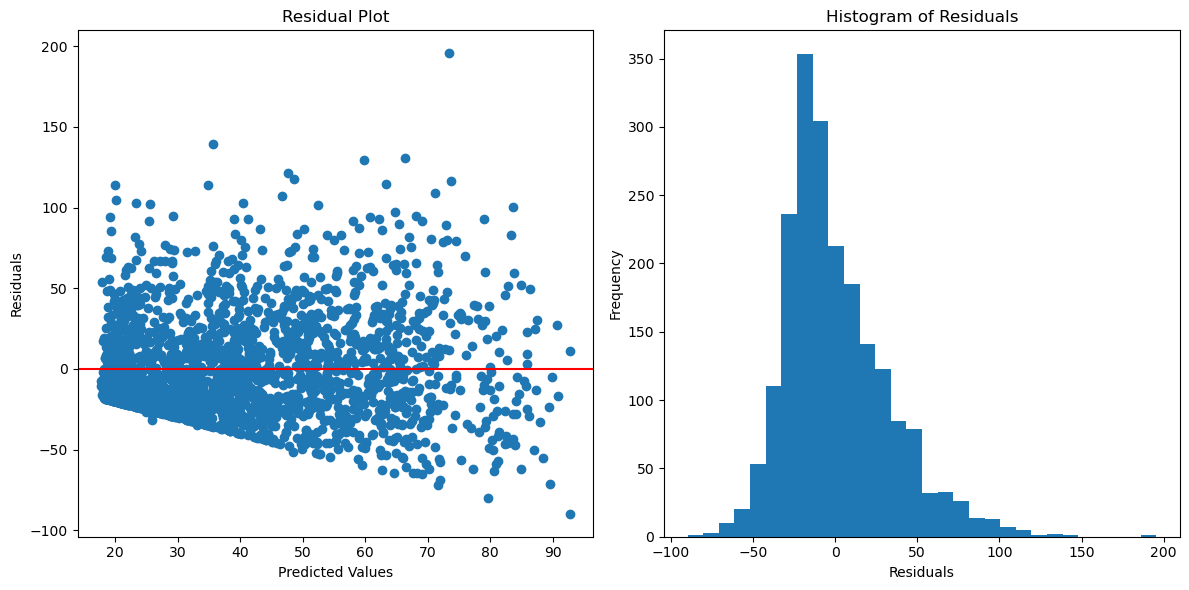

In [12]:
# Calculate residuals
residuals = y_test - y_pred_test

# Create error plots
plt.figure(figsize=(12, 6))

# Residual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

plt.tight_layout()
plt.show()

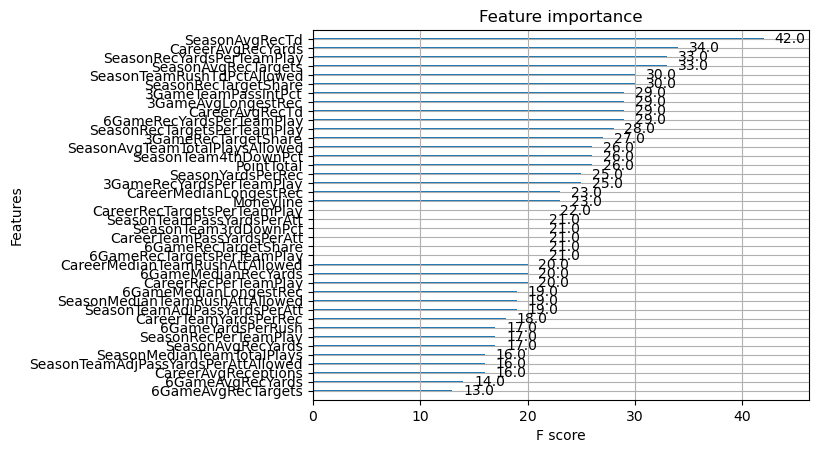

<Figure size 1800x1200 with 0 Axes>

In [13]:
# Plot feature importance
xgboost.plot_importance(best_xgb, max_num_features=40)
plt.figure(figsize=(18, 12))
plt.show()

### Persist the best model in the models dir

In [14]:
model_dir = '../../models/{}/'.format(variable)

model_file_path = model_dir + 'xgb_x{}_wr_backtest.pkl'.format(variable.lower())
joblib.dump(best_xgb, model_file_path)

['../../models/RecYards/xgb_xrecyards_wr_backtest.pkl']

In [15]:
# Save the model features as a file in models dir to make prod use easier
features_file_path = model_dir + 'features/xgb_x{}_wr_backtest.features'.format(variable.lower())

# Open the .txt file in write mode and write the data
with open(features_file_path, 'w') as file:
    for item in features:
        file.write(f"{item}\n")

                                Feature  Importance
0            6GameRecTargetsPerTeamPlay    0.164131
1                     CareerAvgRecYards    0.118151
36                   6GameAvgRecTargets    0.088078
2                   6GameRecTargetShare    0.076937
3                     SeasonAvgRecYards    0.049254
9           CareerRecTargetsPerTeamPlay    0.046085
5                      6GameAvgRecYards    0.045092
4                  CareerRecPerTeamPlay    0.042204
10                  6GameMedianRecYards    0.035568
15                  CareerAvgReceptions    0.031198
6                   SeasonAvgRecTargets    0.028479
14                 SeasonRecTargetShare    0.018074
7              6GameRecYardsPerTeamPlay    0.017312
13          SeasonRecTargetsPerTeamPlay    0.016827
21            SeasonRecYardsPerTeamPlay    0.013620
11                  6GameRecPerTeamPlay    0.013526
23                  3GameRecTargetShare    0.012843
16                       CareerAvgRecTd    0.012513
8           

<Figure size 1000x800 with 0 Axes>

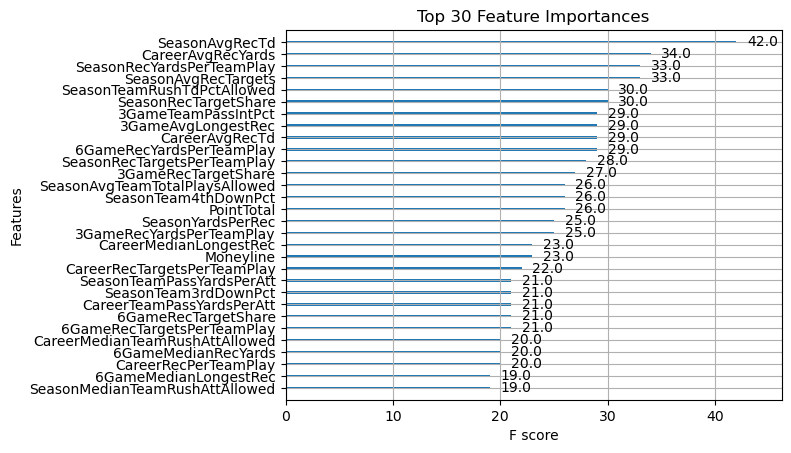

In [16]:
from xgboost import XGBRegressor, plot_importance
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `best_xgb_linear` is your trained model and `X_train` is your original training data

# Step 1: Extract feature importances from the model
feature_importances = best_xgb.feature_importances_

# Step 2: Create a DataFrame to display feature names and their corresponding importance
feature_names = X_train.columns  # Use original feature names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
useful_features = importance_df[importance_df['Importance'] > 0]
not_useful_features = importance_df[importance_df['Importance'] <= 0]
print(useful_features)

# Step 3: Plot feature importance using XGBoost's built-in plotting function
plt.figure(figsize=(10, 8))
plot_importance(best_xgb, importance_type='weight', max_num_features=30)  # Plot top 30 features by default
plt.title('Top 30 Feature Importances')
plt.show()



In [17]:
print("Total Features: {}".format(len(features)))
print("Useful Features: {}".format(len(useful_features)))
print("Not Useful Features: {}".format(len(not_useful_features)))


Total Features: 43
Useful Features: 43
Not Useful Features: 0


In [18]:
useful_features.Feature.tolist()

['6GameRecTargetsPerTeamPlay',
 'CareerAvgRecYards',
 '6GameAvgRecTargets',
 '6GameRecTargetShare',
 'SeasonAvgRecYards',
 'CareerRecTargetsPerTeamPlay',
 '6GameAvgRecYards',
 'CareerRecPerTeamPlay',
 '6GameMedianRecYards',
 'CareerAvgReceptions',
 'SeasonAvgRecTargets',
 'SeasonRecTargetShare',
 '6GameRecYardsPerTeamPlay',
 'SeasonRecTargetsPerTeamPlay',
 'SeasonRecYardsPerTeamPlay',
 '6GameRecPerTeamPlay',
 '3GameRecTargetShare',
 'CareerAvgRecTd',
 '3GameRecYardsPerTeamPlay',
 'PointTotal',
 'Moneyline',
 'CareerTeamPassYardsPerAtt',
 '3GameMedianLongestRec',
 'CareerMedianLongestRec',
 '3GameTeamPassIntPct',
 'SeasonAvgRecTd',
 '3GameAvgLongestRec',
 'SeasonTeamAdjPassYardsPerAtt',
 '6GameMedianLongestRec',
 'SeasonRecPerTeamPlay',
 'SeasonTeam3rdDownPct',
 'CareerTeamYardsPerRec',
 'SeasonTeamAdjPassYardsPerAttAllowed',
 'SeasonTeamRushTdPctAllowed',
 'SeasonAvgTeamTotalPlaysAllowed',
 'SeasonMedianTeamRushAttAllowed',
 'SeasonTeamPassYardsPerAtt',
 'SeasonMedianTeamTotalPlays',
 

In [25]:
features

['6GameRecTargetsPerTeamPlay',
 'CareerAvgRecYards',
 '6GameRecTargetShare',
 'SeasonAvgRecYards',
 'CareerRecPerTeamPlay',
 '6GameAvgRecYards',
 'SeasonAvgRecTargets',
 '6GameRecYardsPerTeamPlay',
 '3GameRecYardsPerTeamPlay',
 'CareerRecTargetsPerTeamPlay',
 '6GameMedianRecYards',
 '6GameRecPerTeamPlay',
 'SeasonRecPerTeamPlay',
 'SeasonRecTargetsPerTeamPlay',
 'SeasonRecTargetShare',
 'CareerAvgReceptions',
 'CareerAvgRecTd',
 'SeasonTeamRushTdPctAllowed',
 '3GameAvgLongestRec',
 'SeasonAvgRecTd',
 'SeasonTeamAdjPassYardsPerAtt',
 'SeasonRecYardsPerTeamPlay',
 'PointTotal',
 '3GameRecTargetShare',
 'Moneyline',
 'CareerTeamPassYardsPerAtt',
 'CareerMedianLongestRec',
 'CareerMedianTeamRushAttAllowed',
 'SeasonMedianTeamRushAttAllowed',
 'SeasonTeam4thDownPct',
 '6GameMedianLongestRec',
 '3GameMedianLongestRec',
 '3GameTeamPassIntPct',
 'SeasonYardsPerRec',
 'CareerTeamYardsPerRec',
 'SeasonTeamAdjPassYardsPerAttAllowed',
 '6GameAvgRecTargets',
 'SeasonAvgTeamTotalPlaysAllowed',
 '6Ga